In [1]:
from neural_bandits.modules.neural_ucb_module import NeuralUCBBanditModule
from neural_bandits.datasets.statlog import StatlogDataset

import lightning as pl
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
class Network(nn.Module):
    def __init__(self, dim, hidden_size=100):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        return self.fc2(self.activate(self.fc1(x)))

In [3]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

network = Network(dataset.context_size * dataset.num_actions, hidden_size=100)

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = NeuralUCBBanditModule(
        n_features = dataset.context_size * dataset.num_actions,
        network=network,
        early_stop_threshold=1e-3,
        num_grad_steps=1000,
        lambda_=0.1,
        nu=1.0,
        learning_rate=0.02,
        train_freq=10000,
        initial_train_steps=100,
)

logger = pl.pytorch.loggers.CSVLogger("logs", name="neural_ucb", flush_logs_every_n_steps=100)
trainer = pl.Trainer(max_epochs=1, logger=logger, log_every_n_steps=1)

GPU available: False, used: False


7
58000


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [4]:
trainer.fit(model, train_loader)


  | Name   | Type            | Params | Mode 
---------------------------------------------------
0 | bandit | NeuralUCBBandit | 6.5 K  | train
---------------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
c:\Users\Parisa\anaconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 58000/58000 [32:41<00:00, 29.57it/s, v_num=16, reward=0.000, regret=1.000] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 58000/58000 [32:41<00:00, 29.57it/s, v_num=16, reward=0.000, regret=1.000]


In [8]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

metrics_csv = logger.log_dir + "/metrics.csv"
print(metrics_csv)
metrics = pd.read_csv("logs\\neural_ucb\\version_14/metrics.csv")
cumulative_reward = np.cumsum(metrics["reward"][:10000])
cumulative_regret = np.cumsum(metrics["regret"][:10000])

logs\neural_ucb\version_16/metrics.csv


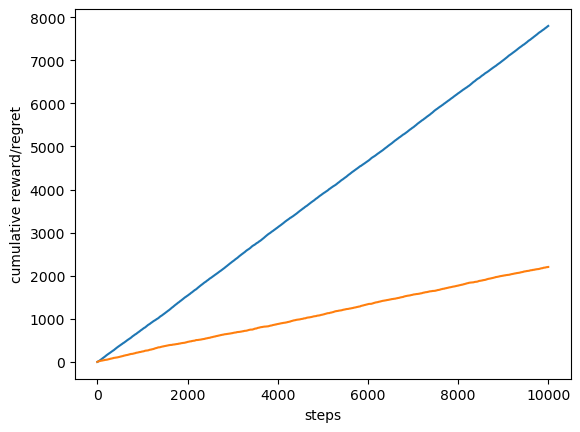

In [9]:
import matplotlib.pyplot as plt
plt.plot(cumulative_reward)
plt.plot(cumulative_regret)
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.show()

In [7]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)

print(sum(metrics["regret"][:100]) / 100)
print(sum(metrics["regret"][:1000]) / 1000)
print(sum(metrics["regret"][:10000]) / 10000)


0.69
0.759
0.7796
0.31
0.241
0.2204
